In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import moscot
from moscot.problems.time import TemporalProblem
import moscot.plotting as mpl
import pandas as pd
import os

import mplscience

mplscience.available_styles()
mplscience.set_style(reset_current=True)
plt.rcParams['legend.scatterpoints'] = 1 

['default', 'despine']


In [3]:
output_dir = "."

In [4]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/moscot_paper/pancreas/embeddings/pancreas_shared_embeddings.h5ad")

In [5]:
new_annotation = pd.read_csv("../EDA/endocrine_refinement.csv")

In [6]:
adata.obs["Fev_delta_refinement"] = new_annotation["Fev_delta_refinement"].values
adata.obs["Ngn3_high_refinement"] = new_annotation["Ngn3_high_refinement"].values

In [7]:
adata_2 = sc.read_h5ad("/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_multiome_2022_processed.h5ad")

In [8]:
endocrine_celltypes = [
    "Ngn3 low",
    "Ngn3 high",
    "Ngn3 high cycling",
    "Fev+",
    "Fev+ Alpha",
    "Fev+ Beta",
    "Fev+ Delta",
    "Eps. progenitors",
    "Alpha",
    "Beta",
    "Delta",
    "Epsilon"
]

In [9]:
adata_red = adata_2[adata_2.obs["celltype"].isin(endocrine_celltypes)].copy()
adata = adata[adata.obs["celltype"].isin(endocrine_celltypes)].copy()

In [10]:
sc.tl.umap(adata_red)

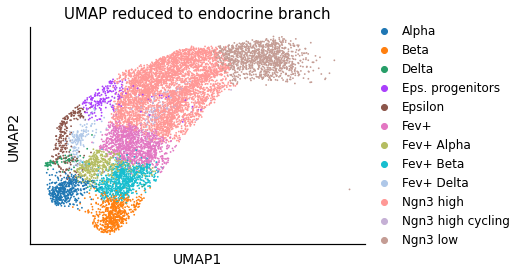

In [11]:
sc.pl.umap(adata_red, color="celltype", title="UMAP reduced to endocrine branch")

In [12]:
adata.obs['time'] = adata.obs.apply(lambda x: 14.5 if x["sample"]=="E14.5" else 15.5, axis=1)

In [13]:
adata.obsm["umap"] = adata_red.obsm["umap"]

In [14]:
def create_col(x):
    if x["celltype"] == "Ngn3 high":
        return x["Ngn3_high_refinement"]
    if x["celltype"] == "Fev+ Delta":
        return x["Fev_delta_refinement"]
    return x["celltype"]

adata.obs["refinement"] = adata.obs.apply(create_col, axis=1)

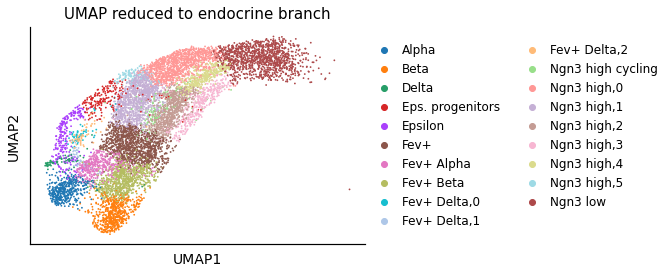

In [15]:
fig = sc.pl.umap(adata, color="refinement", title="UMAP reduced to endocrine branch", show=False)

In [16]:
fig.figure.savefig(os.path.join(output_dir, 'umap_endocrine_refinement.png'))

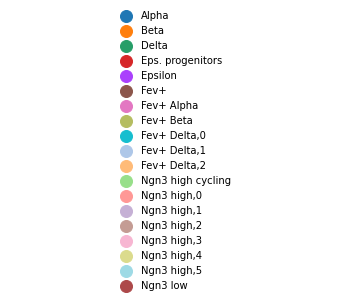

In [17]:
label_params = fig.get_legend_handles_labels() 
figl, axl = plt.subplots()
axl.axis(False)
axl.legend(*label_params, fontsize=5, loc="center", markerscale=2, bbox_to_anchor=(0.5, 0.5), prop={"size":10})

In [18]:
axl.figure.savefig(os.path.join(output_dir, 'endocrine_refinement_legend_only.png'))

# Heat kernel distances

In [19]:
import pygsp

In [20]:
sc.pp.neighbors(adata, use_rep="X_multi_vi", key_added="multi_vi", n_neighbors=30)

In [21]:
cell_ids_source = adata[adata.obs["time"]==14.5].obs_names
cell_ids_target = adata[adata.obs["time"]==15.5].obs_names

In [22]:
assert (adata.obs.iloc[:(len(cell_ids_source))].index == cell_ids_source).all()
assert (adata.obs.iloc[(len(cell_ids_source)):].index == cell_ids_target).all()

In [23]:
G = pygsp.graphs.Graph(adata.obsp["multi_vi_connectivities"])

In [24]:
G.estimate_lmax()

In [25]:
filt = pygsp.filters.Heat(G, tau=100)
diffusion_distances = filt.filter(np.eye(len(adata)))
custom_cost = pd.DataFrame(data=-np.log(diffusion_distances[:len(cell_ids_source), len(cell_ids_source):].copy())+1e-15, index=cell_ids_source, columns=cell_ids_target)

In [26]:
tp0 = TemporalProblem(adata)
tp0 = tp0.prepare("time", joint_attr="X_multi_vi")

In [27]:
tp0[14.5, 15.5].set_xy(custom_cost, tag="cost")

In [28]:
tp0 = tp0.solve(max_iterations=1e8)

INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(5539, 3826)].            


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

In [24]:
order_celltypes = ['Ngn3 low', 'Ngn3 high cycling', 'Ngn3 high', 'Eps. progenitors', 'Fev+', 'Fev+ Alpha', 
                   'Fev+ Beta', 'Fev+ Delta', 'Alpha', 'Beta', 'Delta', 'Epsilon']

In [25]:
_ = tp0.cell_transition(14.5, 15.5, {"celltype": order_celltypes}, {"celltype": order_celltypes}, forward=False)

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

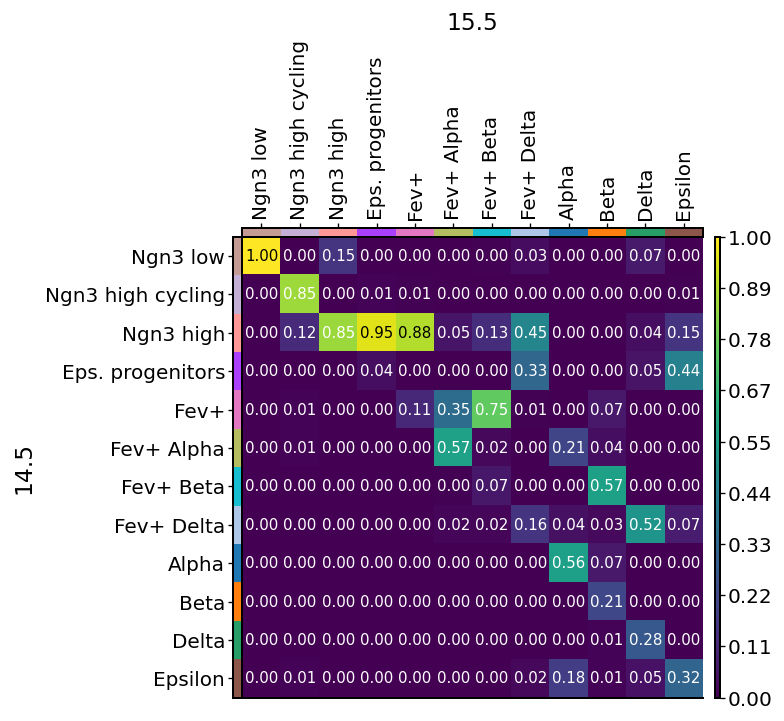

In [26]:
mpl.cell_transition(tp0, dpi=120, fontsize=9)

In [27]:
_ = tp0.cell_transition(14.5, 15.5, {"celltype": order_celltypes}, {"celltype": order_celltypes}, forward=True)

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

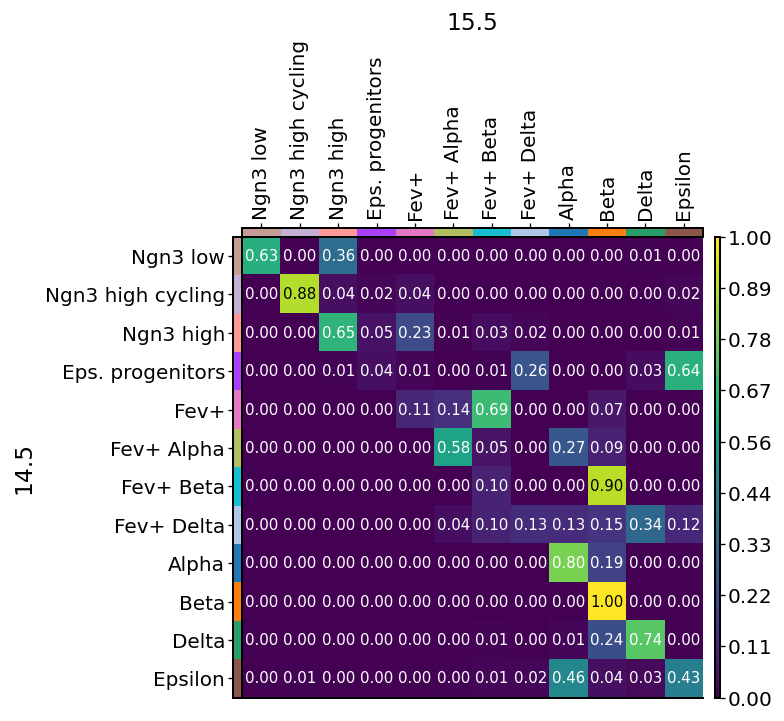

In [28]:
mpl.cell_transition(tp0, dpi=120, fontsize=9)

In [29]:
tp0.push(14.5, 15.5, data="celltype", subset="Eps. progenitors")

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


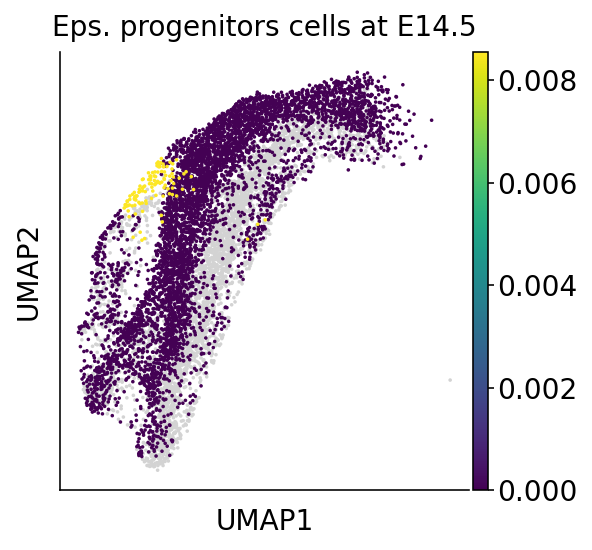

In [30]:
mpl.push(tp0, time_points=[14.5], basis="umap", title="Eps. progenitors cells at E14.5")

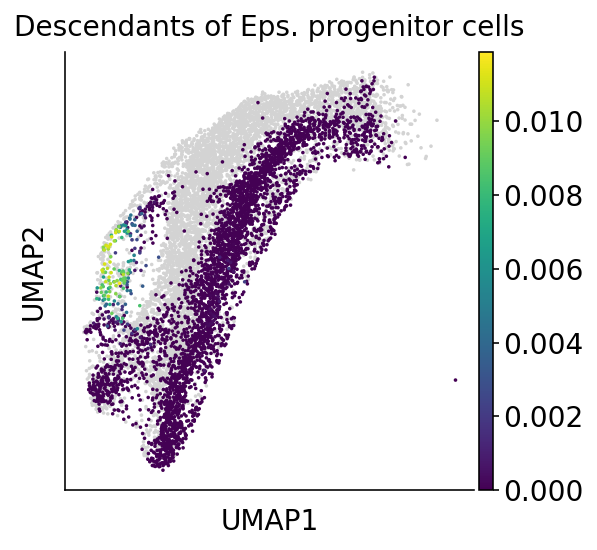

In [31]:
mpl.push(tp0, time_points=[15.5], title="Descendants of Eps. progenitor cells")

In [32]:
tp0.push(14.5, 15.5, data="refinement", subset="Ngn3 high,5")

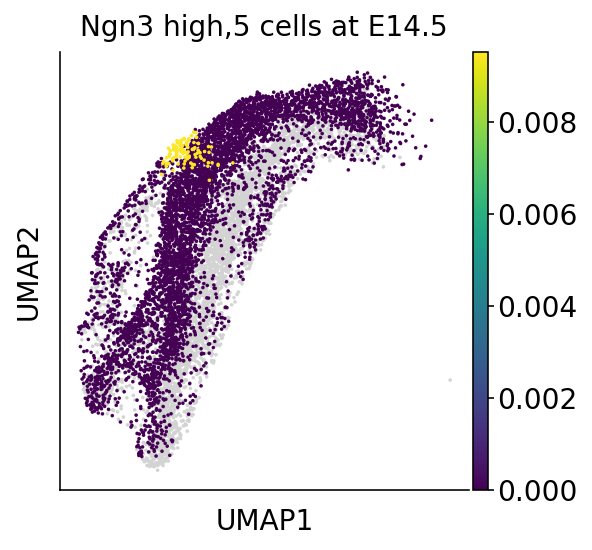

In [33]:
mpl.push(tp0, time_points=[14.5], basis="umap", title="Ngn3 high,5 cells at E14.5")

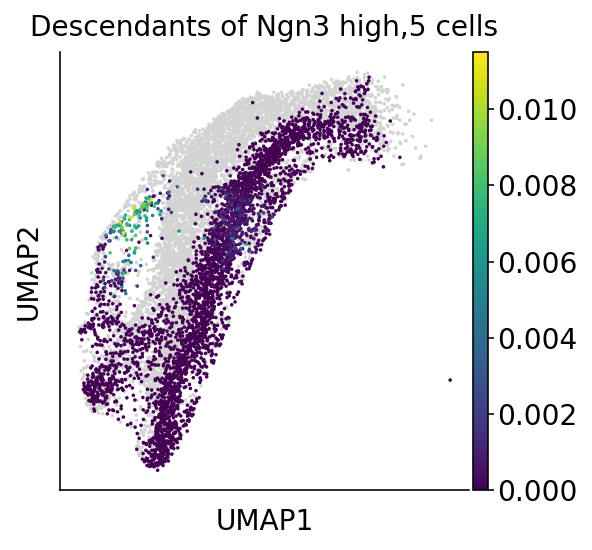

In [34]:
mpl.push(tp0, time_points=[15.5], basis="umap", title="Descendants of Ngn3 high,5 cells")

In [35]:
cluster_subset = ["Ngn3 high,5", "Eps. progenitors", "Fev+ Delta,0", "Fev+ Delta,1", "Fev+ Delta,2", "Epsilon", "Delta"]

In [67]:
_ = tp0.cell_transition(14.5, 15.5, {"refinement": cluster_subset}, {"refinement": cluster_subset}, forward=True)

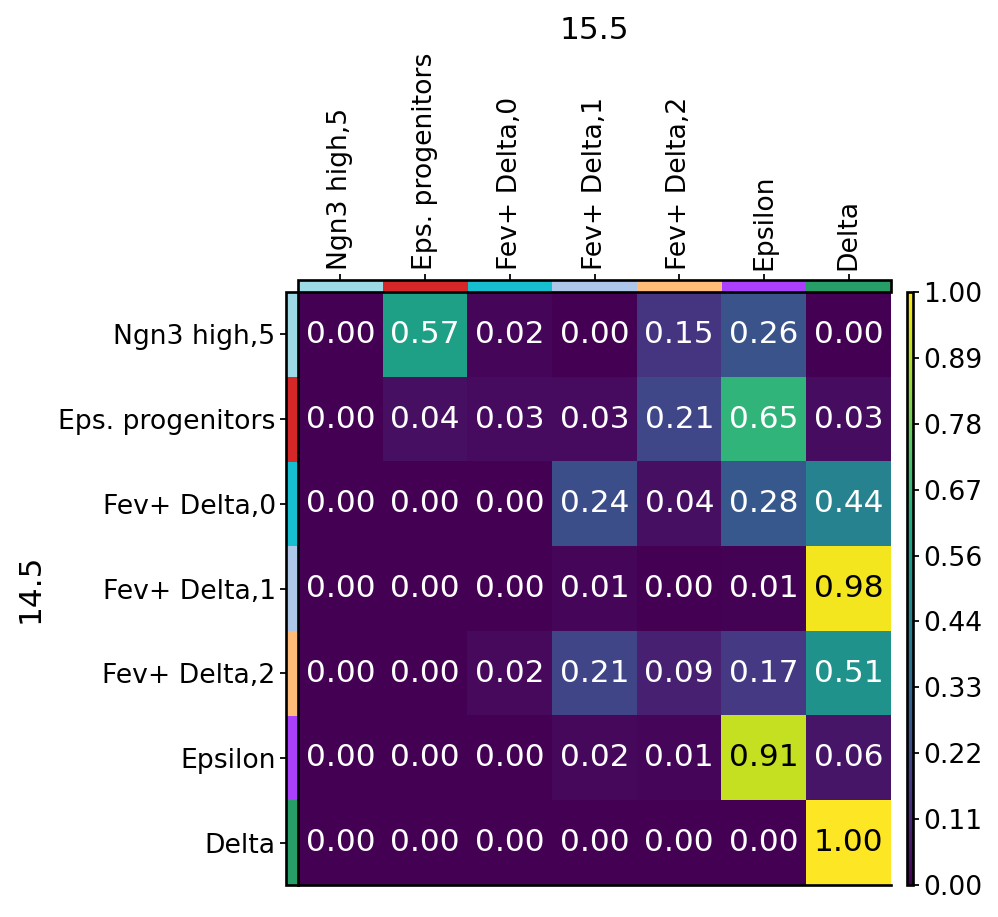

In [68]:
mpl.cell_transition(tp0, dpi=80, fontsize=14)

In [69]:
_ = tp0.cell_transition(14.5, 15.5, {"refinement": cluster_subset}, {"refinement": cluster_subset}, forward=False)

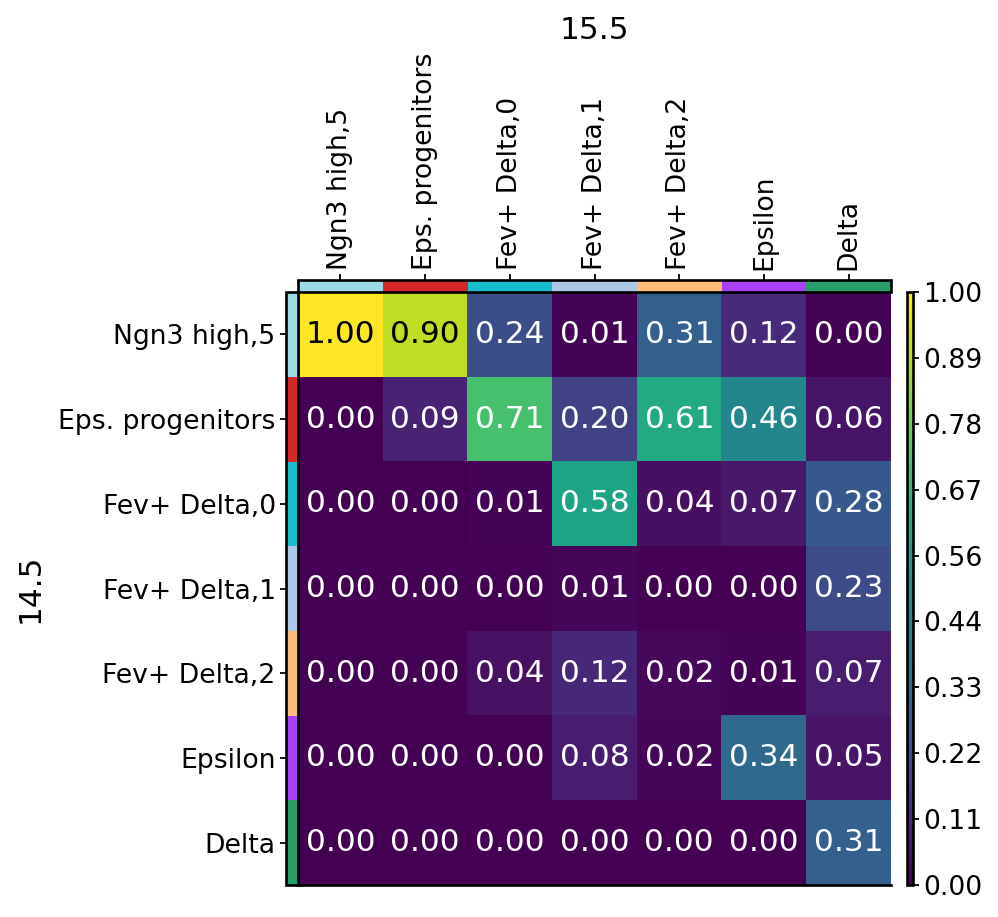

In [70]:
mpl.cell_transition(tp0, dpi=80, fontsize=14)

In [40]:
tp0.pull(14.5, 15.5, data="celltype", subset="Epsilon")

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


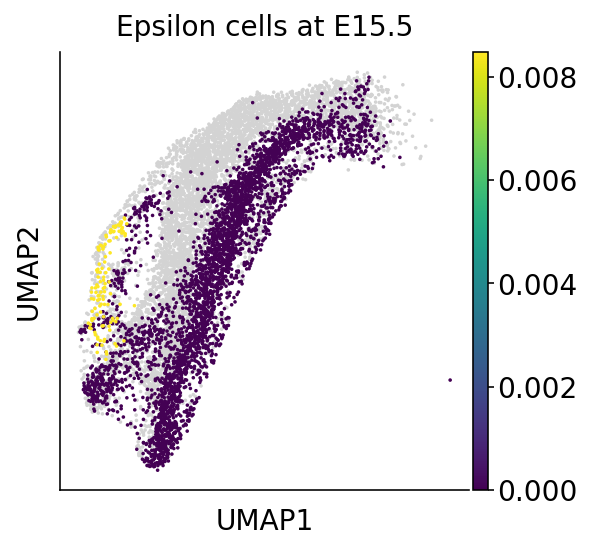

In [41]:
mpl.pull(tp0, time_points=[15.5], basis="umap", title="Epsilon cells at E15.5")

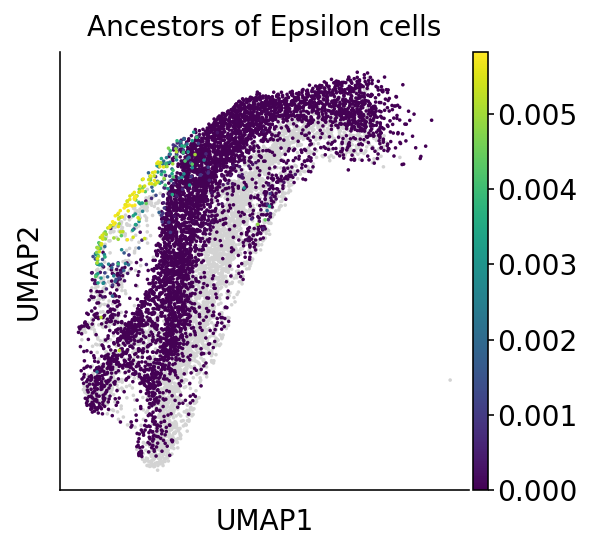

In [42]:
mpl.pull(tp0, time_points=[14.5], basis="umap", title="Ancestors of Epsilon cells")

In [43]:
tp0.pull(14.5, 15.5, data="celltype", subset="Eps. progenitors")

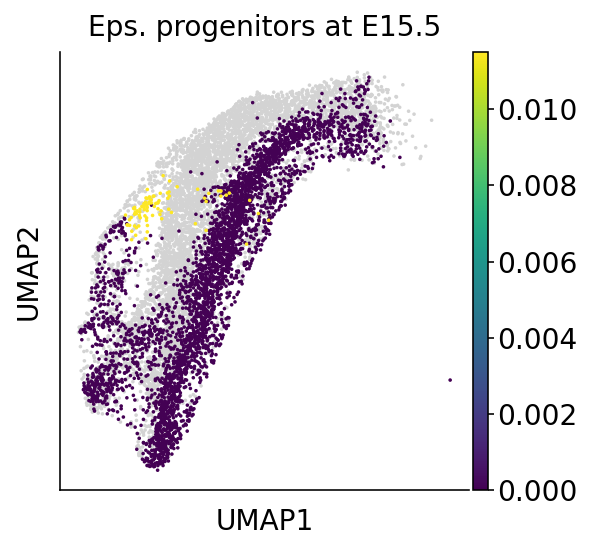

In [44]:
mpl.pull(tp0, time_points=[15.5], basis="umap", title="Eps. progenitors at E15.5")

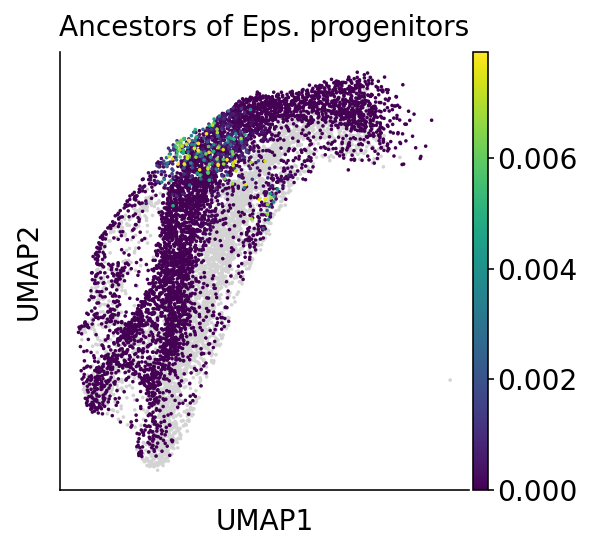

In [45]:
mpl.pull(tp0, time_points=[14.5], basis="umap", title="Ancestors of Eps. progenitors")

In [46]:
tp0.pull(14.5, 15.5, data="celltype", subset="Delta")

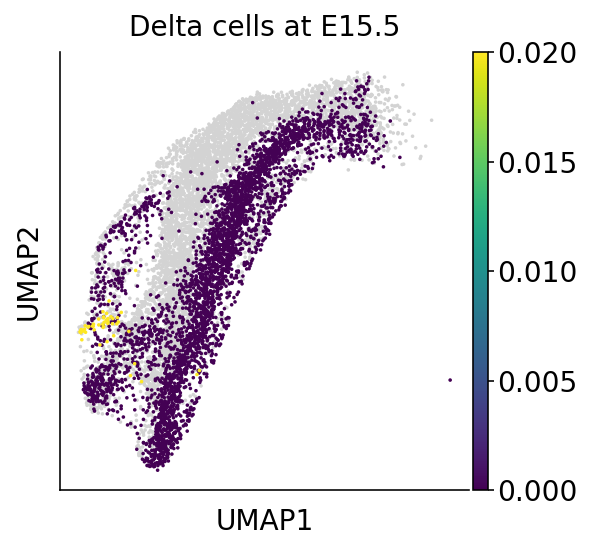

In [47]:
mpl.pull(tp0, time_points=[15.5], basis="umap", title="Delta cells at E15.5")

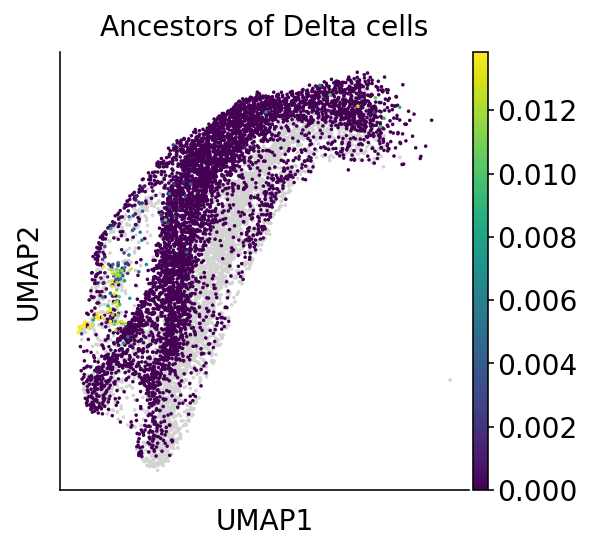

In [48]:
mpl.pull(tp0, time_points=[14.5], basis="umap", title="Ancestors of Delta cells")

In [72]:
_ = tp0.cell_transition(14.5, 15.5, "refinement", "refinement", forward=False)

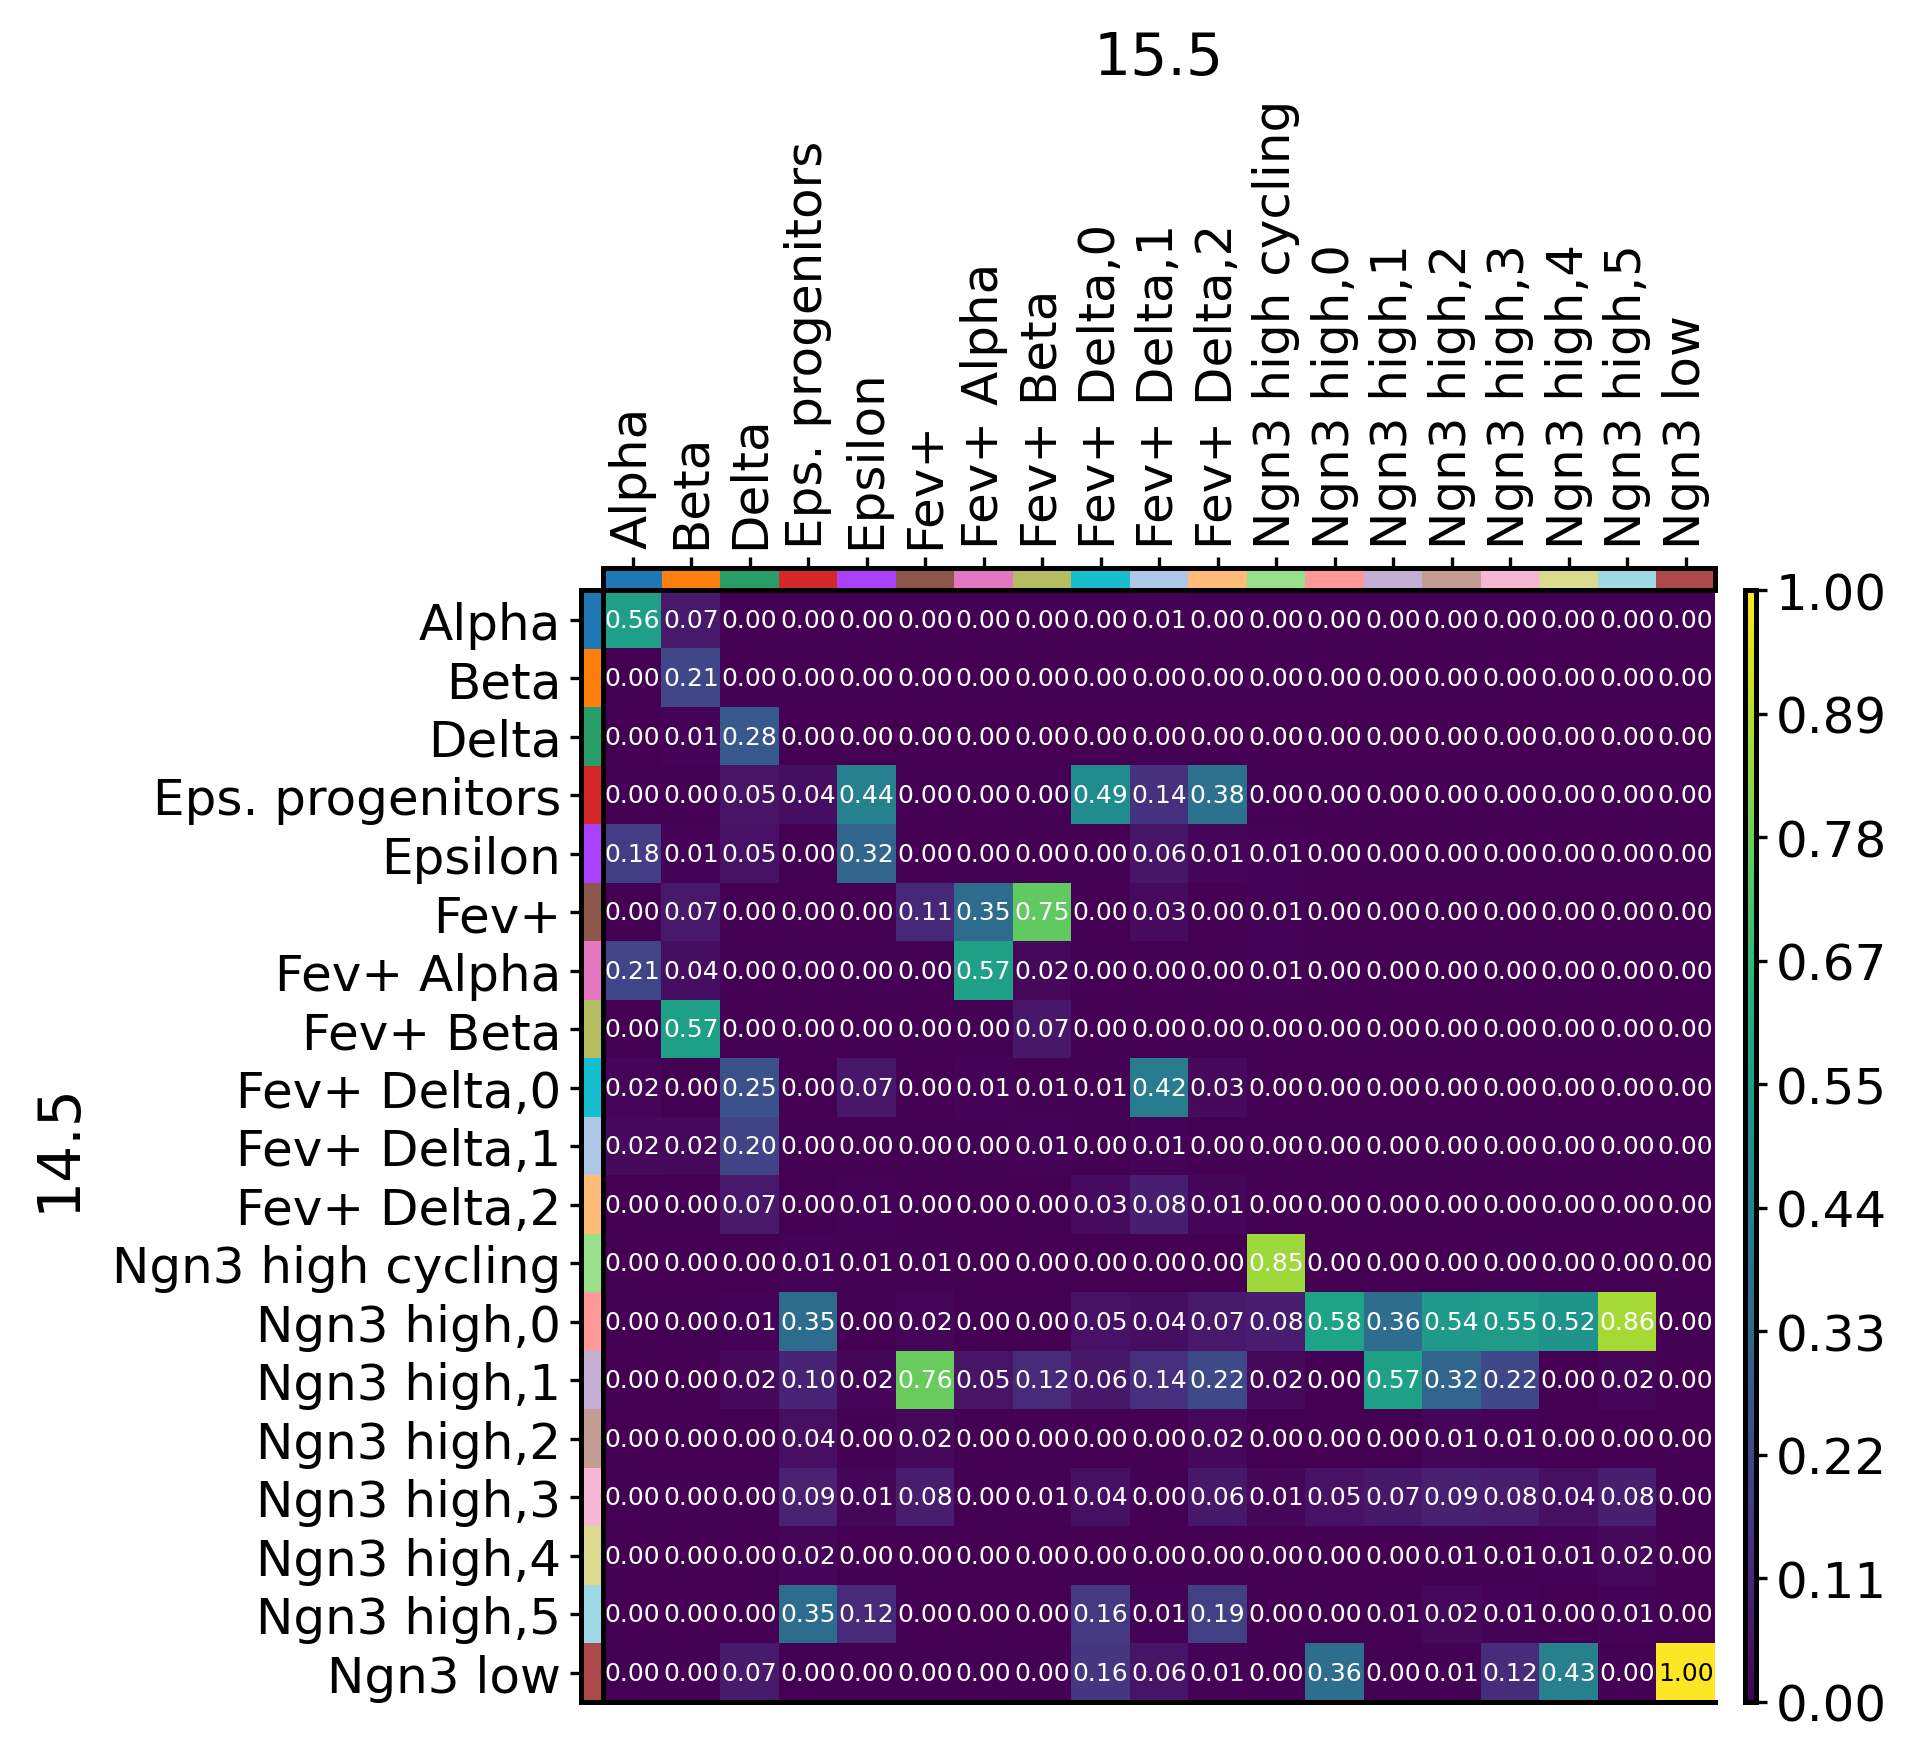

In [73]:
mpl.cell_transition(tp0, dpi=150, fontsize=6)

In [74]:
_ = tp0.cell_transition(14.5, 15.5, "refinement", "refinement", forward=True)

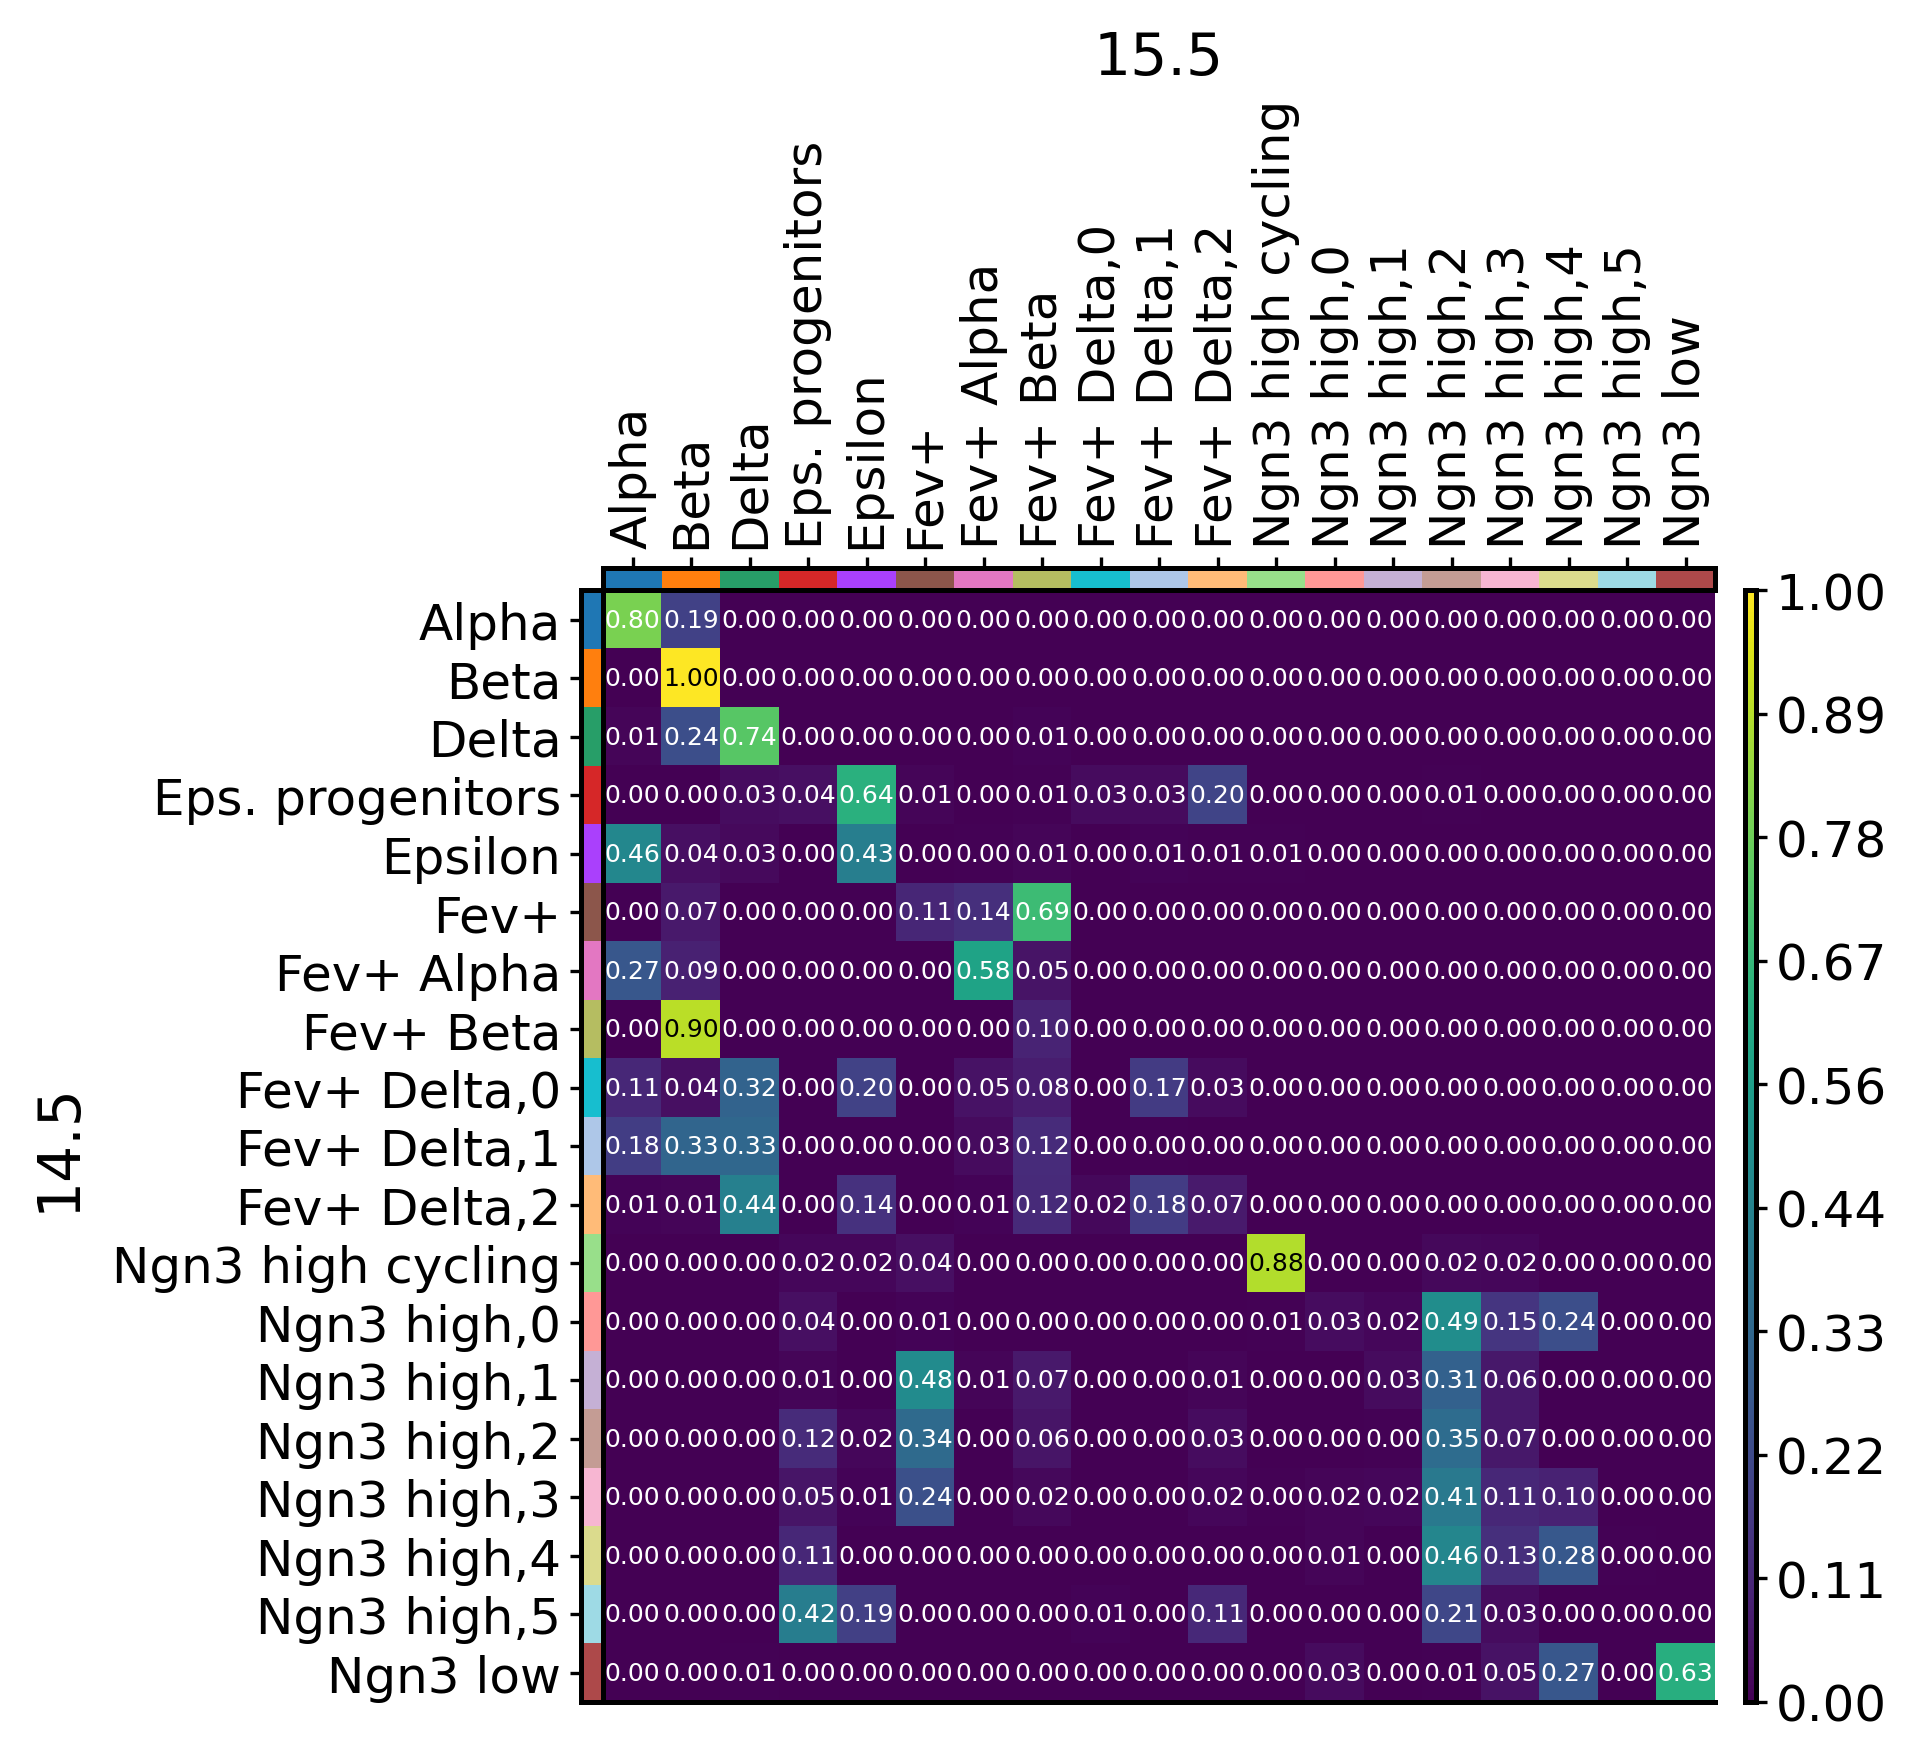

In [75]:
mpl.cell_transition(tp0, dpi=150, fontsize=6)